In [1]:
from az_common_funcs import *

2024-04-03 17:12:38,015 :: [INFO] :: Logger initialized WITHOUT file handler


In [26]:
import pandas as pd
import numpy as np
sns.set_theme()

In [36]:
import shap
shap.initjs()

In [3]:
df = pd.read_parquet(f"{temp_dir}/s4_feature_creation_taaco_checkpoint.parquet")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25752 entries, 0 to 25751
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   review_id                       25752 non-null  int64  
 1   sent_gte_3                      25752 non-null  bool   
 2   cognitive_score                 25752 non-null  float64
 3   affective_score                 25752 non-null  float64
 4   spatial_embedding_score         25752 non-null  int64  
 5   temporal_embedding_score        25752 non-null  int64  
 6   narrativity_label               25752 non-null  object 
 7   doc_a                           25752 non-null  object 
 8   review_length                   25752 non-null  int64  
 9   review_num_sentences            25752 non-null  int64  
 10  NER                             25752 non-null  object 
 11  count_adjectives                25752 non-null  int64  
 12  count_adverbs                   

In [5]:
df['narrativity_label'] = df['narrativity_label'].map({'good' : 1, 'bad' : 0})

In [6]:
df['count_new_info_all'] = df[['count_unique_locations', 'count_unique_persons', 'count_unique_activites', 'count_unique_products', 'count_unique_attributes']].sum(axis=1)

In [7]:
identity_feature = ['review_id']

pt_1_num_words = ['review_length']
pt_2_sub_pred_clauses = ['count_sub_predicates']
pt_3_elaboration = ['count_adjectives', 'count_adverbs']
# pt_4_new_info = ['count_unique_locations', 'count_unique_persons', 'count_unique_activites', 'count_unique_products', 'count_unique_attributes']
pt_4_new_info = ['count_new_info_all']
pt_5_cohesion = ['cohesion_pc1', 'cohesion_pc2', 'cohesion_pc3', 'cohesion_pc4', 'cohesion_pc5', 'cohesion_pc6', 'cohesion_pc7', 'cohesion_pc8', 'cohesion_pc9', 'cohesion_pc10']
pt_6_coherence = ['cohesion_score_roberta', 'count_interclausal_connectives', 'count_temporal_connectives', 'count_causal_connectives']
pt_7_contextual_emb = ['count_all_where_ner', 'count_all_when_ner']

target_feature = ['narrativity_label']

In [8]:
df_train = df[identity_feature + pt_1_num_words + pt_2_sub_pred_clauses + pt_3_elaboration + pt_4_new_info + pt_5_cohesion + pt_6_coherence + pt_7_contextual_emb + target_feature]

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25752 entries, 0 to 25751
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   review_id                       25752 non-null  int64  
 1   review_length                   25752 non-null  int64  
 2   count_sub_predicates            25752 non-null  int64  
 3   count_adjectives                25752 non-null  int64  
 4   count_adverbs                   25752 non-null  int64  
 5   count_new_info_all              25752 non-null  int64  
 6   cohesion_pc1                    25749 non-null  float64
 7   cohesion_pc2                    25749 non-null  float64
 8   cohesion_pc3                    25749 non-null  float64
 9   cohesion_pc4                    25749 non-null  float64
 10  cohesion_pc5                    25749 non-null  float64
 11  cohesion_pc6                    25749 non-null  float64
 12  cohesion_pc7                    

In [10]:
import xgboost as xgb

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [92]:
class XGBoostClassifier_f2:
    def __init__(self, data):
        self.data = data
        self.identity_variable = 'review_id'
        self.target_variable = None
        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        self.model = None
        
    def split_data(self, target_variable):
        self.target_variable = target_variable
        X = self.data.drop(target_variable, axis=1)
        y = self.data[target_variable]
        
        self.X_train, X_test, self.y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
        self.X_test, self.X_val, self.y_test, self.y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=42)
        
    def train_model(self, use_val=False, no_cache=False):
        n_estimators = 2000 
        max_depth = 3
        learning_rate = 0.03
        tree_method = 'approx'
        random_state=42
        
        save_dir = temp_dir
        model_name = f"xgb_classifier_{n_estimators}_{max_depth}_{learning_rate*1000:.0}_{tree_method}_{random_state}.json"
        
        if no_cache:
            self._fit_model(n_estimators, max_depth, learning_rate, tree_method, random_state, use_val, save_dir, model_name)
        else:
            self.model = self._fetch_cached_model(save_dir, model_name)
            if self.model == None:
                self._fit_model(n_estimators, max_depth, learning_rate, tree_method, random_state, use_val, save_dir, model_name)
            
    def _fit_model(self, n_estimators, max_depth, learning_rate, tree_method, random_state, use_val, save_dir, model_name):
        self.model = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate,
                                       tree_method = tree_method, verbosity = 1, random_state=random_state,
                                       eval_metric='aucpr', early_stopping_rounds=100)
        if use_val:
            self.model.fit(
            self.X_train.drop(self.identity_variable, axis = 1),
            self.y_train,
            eval_set=[
                (self.X_train.drop(self.identity_variable, axis = 1), self.y_train),
                (self.X_val.drop(self.identity_variable, axis = 1), self.y_val)
            ],
            verbose=True
            )
        else:
            self.model.fit(self.X_train.drop(self.identity_variable, axis = 1), self.y_train)

        self.model.save_model(f"{save_dir}/{model_name}")
        print("model saved at : ", f"{save_dir}/{model_name}")
    
    def _fetch_cached_model(self, save_dir, model_name):
        file = glob.glob(f"{save_dir}/{model_name}")
        if file:
            print("Cached Model Found. Loading it. If you want to train from scratch, set no_cache to True in train.")
            model = XGBClassifier()
            model.load_model(file[0])
            return model
        else:
            print("No Cached Model Found. Training from scratch.")
            return None        
    
    def evaluate_model(self, include_val=False, include_train=False):
        sets_to_evaluate = [('Test', self.X_test.drop(self.identity_variable, axis = 1), self.y_test)]
        
        if include_val:
            sets_to_evaluate.append(('Validation', self.X_val.drop(self.identity_variable, axis = 1), self.y_val))
        
        if include_train:
            sets_to_evaluate.append(('Training', self.X_train.drop(self.identity_variable, axis = 1), self.y_train))
        
        for set_name, X, y in sets_to_evaluate:
            y_pred = self.model.predict(X)
            y_pred_proba = self.model.predict_proba(X)[:, 1]
            
            print(f"{set_name} Set Evaluation:")
            print("-------------------")
            
            f1 = f1_score(y, y_pred)
            cm = confusion_matrix(y, y_pred)
            precision = precision_score(y, y_pred)
            recall = recall_score(y, y_pred)
            roc_auc = roc_auc_score(y, y_pred_proba)
            auprc = average_precision_score(y, y_pred_proba)
            
            print("F1 Score:", f1)
            print("Confusion Matrix:\n", cm)
            print("Precision:", precision)
            print("Recall:", recall)
            print("ROC AUC Score:", roc_auc)
            print("AUPRC Score:", auprc)
            print()
        
    def visualize_results(self):
        
        y_pred_proba = self.model.predict_proba(self.X_val.drop(self.identity_variable, axis = 1))[:, 1]
        
        plt.figure(figsize=(8, 6))
        sns.histplot(y_pred_proba, bins=20, kde=True)
        plt.xlabel("Predicted Probability")
        plt.ylabel("Frequency")
        plt.title("Distribution of Predicted Probabilities")
        plt.show()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(self.y_val, self.model.predict(self.X_val.drop(self.identity_variable, axis = 1))), annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()
        
        xgb.plot_importance(self.model)
        
        xgb.plot_importance(self.model, importance_type="gain")

    def fine_tune_hyperparameters(self, param_grid):
        grid_search = GridSearchCV(
            estimator=XGBClassifier(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='roc_auc',
            verbose=3,
            n_jobs=-1
        )
        
        grid_search.fit(self.X_train.drop(self.identity_variable, axis = 1), self.y_train)
        
        print("Best hyperparameters:", grid_search.best_params_)
        print("Best ROC AUC score:", grid_search.best_score_)
        
        self.model = grid_search.best_estimator_
        
    def build_shap_explainer(self):
    
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X_test.drop(self.identity_variable, axis = 1))
        
        return explainer, shap_values, self.X_test.drop(self.identity_variable, axis = 1)

In [93]:
clf1 = XGBoostClassifier_f2(df_train)

In [94]:
clf1.split_data(target_feature[0])

In [95]:
clf1.train_model(use_val=True, no_cache=True)

[0]	validation_0-aucpr:0.97573	validation_1-aucpr:0.97101
[1]	validation_0-aucpr:0.97592	validation_1-aucpr:0.97120
[2]	validation_0-aucpr:0.97669	validation_1-aucpr:0.97214
[3]	validation_0-aucpr:0.97934	validation_1-aucpr:0.97528
[4]	validation_0-aucpr:0.97994	validation_1-aucpr:0.97603
[5]	validation_0-aucpr:0.98005	validation_1-aucpr:0.97605
[6]	validation_0-aucpr:0.98005	validation_1-aucpr:0.97604
[7]	validation_0-aucpr:0.98131	validation_1-aucpr:0.97687
[8]	validation_0-aucpr:0.98600	validation_1-aucpr:0.98302
[9]	validation_0-aucpr:0.98703	validation_1-aucpr:0.98560
[10]	validation_0-aucpr:0.98732	validation_1-aucpr:0.98581
[11]	validation_0-aucpr:0.98735	validation_1-aucpr:0.98589
[12]	validation_0-aucpr:0.98746	validation_1-aucpr:0.98609
[13]	validation_0-aucpr:0.98808	validation_1-aucpr:0.98674
[14]	validation_0-aucpr:0.98813	validation_1-aucpr:0.98678
[15]	validation_0-aucpr:0.98850	validation_1-aucpr:0.98781
[16]	validation_0-aucpr:0.98856	validation_1-aucpr:0.98795
[17]	va

[139]	validation_0-aucpr:0.99772	validation_1-aucpr:0.99815
[140]	validation_0-aucpr:0.99773	validation_1-aucpr:0.99815
[141]	validation_0-aucpr:0.99774	validation_1-aucpr:0.99815
[142]	validation_0-aucpr:0.99775	validation_1-aucpr:0.99817
[143]	validation_0-aucpr:0.99776	validation_1-aucpr:0.99818
[144]	validation_0-aucpr:0.99778	validation_1-aucpr:0.99820
[145]	validation_0-aucpr:0.99779	validation_1-aucpr:0.99821
[146]	validation_0-aucpr:0.99780	validation_1-aucpr:0.99823
[147]	validation_0-aucpr:0.99782	validation_1-aucpr:0.99824
[148]	validation_0-aucpr:0.99783	validation_1-aucpr:0.99824
[149]	validation_0-aucpr:0.99784	validation_1-aucpr:0.99826
[150]	validation_0-aucpr:0.99785	validation_1-aucpr:0.99826
[151]	validation_0-aucpr:0.99786	validation_1-aucpr:0.99828
[152]	validation_0-aucpr:0.99787	validation_1-aucpr:0.99830
[153]	validation_0-aucpr:0.99788	validation_1-aucpr:0.99830
[154]	validation_0-aucpr:0.99789	validation_1-aucpr:0.99830
[155]	validation_0-aucpr:0.99790	validat

[276]	validation_0-aucpr:0.99870	validation_1-aucpr:0.99891
[277]	validation_0-aucpr:0.99870	validation_1-aucpr:0.99891
[278]	validation_0-aucpr:0.99871	validation_1-aucpr:0.99890
[279]	validation_0-aucpr:0.99871	validation_1-aucpr:0.99890
[280]	validation_0-aucpr:0.99871	validation_1-aucpr:0.99891
[281]	validation_0-aucpr:0.99871	validation_1-aucpr:0.99891
[282]	validation_0-aucpr:0.99872	validation_1-aucpr:0.99892
[283]	validation_0-aucpr:0.99872	validation_1-aucpr:0.99892
[284]	validation_0-aucpr:0.99872	validation_1-aucpr:0.99892
[285]	validation_0-aucpr:0.99873	validation_1-aucpr:0.99892
[286]	validation_0-aucpr:0.99873	validation_1-aucpr:0.99893
[287]	validation_0-aucpr:0.99874	validation_1-aucpr:0.99893
[288]	validation_0-aucpr:0.99874	validation_1-aucpr:0.99893
[289]	validation_0-aucpr:0.99874	validation_1-aucpr:0.99894
[290]	validation_0-aucpr:0.99874	validation_1-aucpr:0.99894
[291]	validation_0-aucpr:0.99875	validation_1-aucpr:0.99894
[292]	validation_0-aucpr:0.99875	validat

[413]	validation_0-aucpr:0.99906	validation_1-aucpr:0.99913
[414]	validation_0-aucpr:0.99906	validation_1-aucpr:0.99913
[415]	validation_0-aucpr:0.99906	validation_1-aucpr:0.99913
[416]	validation_0-aucpr:0.99907	validation_1-aucpr:0.99913
[417]	validation_0-aucpr:0.99907	validation_1-aucpr:0.99913
[418]	validation_0-aucpr:0.99907	validation_1-aucpr:0.99913
[419]	validation_0-aucpr:0.99907	validation_1-aucpr:0.99913
[420]	validation_0-aucpr:0.99908	validation_1-aucpr:0.99914
[421]	validation_0-aucpr:0.99908	validation_1-aucpr:0.99914
[422]	validation_0-aucpr:0.99908	validation_1-aucpr:0.99914
[423]	validation_0-aucpr:0.99908	validation_1-aucpr:0.99914
[424]	validation_0-aucpr:0.99908	validation_1-aucpr:0.99914
[425]	validation_0-aucpr:0.99909	validation_1-aucpr:0.99914
[426]	validation_0-aucpr:0.99909	validation_1-aucpr:0.99914
[427]	validation_0-aucpr:0.99909	validation_1-aucpr:0.99914
[428]	validation_0-aucpr:0.99909	validation_1-aucpr:0.99914
[429]	validation_0-aucpr:0.99909	validat

[550]	validation_0-aucpr:0.99929	validation_1-aucpr:0.99921
[551]	validation_0-aucpr:0.99929	validation_1-aucpr:0.99922
[552]	validation_0-aucpr:0.99929	validation_1-aucpr:0.99922
[553]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[554]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[555]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[556]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[557]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[558]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[559]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[560]	validation_0-aucpr:0.99930	validation_1-aucpr:0.99922
[561]	validation_0-aucpr:0.99931	validation_1-aucpr:0.99922
[562]	validation_0-aucpr:0.99931	validation_1-aucpr:0.99922
[563]	validation_0-aucpr:0.99931	validation_1-aucpr:0.99922
[564]	validation_0-aucpr:0.99931	validation_1-aucpr:0.99923
[565]	validation_0-aucpr:0.99931	validation_1-aucpr:0.99923
[566]	validation_0-aucpr:0.99931	validat

[687]	validation_0-aucpr:0.99944	validation_1-aucpr:0.99927
[688]	validation_0-aucpr:0.99944	validation_1-aucpr:0.99928
[689]	validation_0-aucpr:0.99944	validation_1-aucpr:0.99928
[690]	validation_0-aucpr:0.99944	validation_1-aucpr:0.99928
[691]	validation_0-aucpr:0.99944	validation_1-aucpr:0.99928
[692]	validation_0-aucpr:0.99944	validation_1-aucpr:0.99927
[693]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99927
[694]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[695]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[696]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[697]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[698]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[699]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[700]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[701]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[702]	validation_0-aucpr:0.99945	validation_1-aucpr:0.99928
[703]	validation_0-aucpr:0.99945	validat

[824]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[825]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[826]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[827]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[828]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[829]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[830]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[831]	validation_0-aucpr:0.99955	validation_1-aucpr:0.99932
[832]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[833]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[834]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[835]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[836]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[837]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[838]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[839]	validation_0-aucpr:0.99956	validation_1-aucpr:0.99932
[840]	validation_0-aucpr:0.99956	validat

[961]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[962]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[963]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[964]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[965]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[966]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[967]	validation_0-aucpr:0.99964	validation_1-aucpr:0.99934
[968]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[969]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[970]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[971]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[972]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[973]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[974]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[975]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[976]	validation_0-aucpr:0.99965	validation_1-aucpr:0.99934
[977]	validation_0-aucpr:0.99965	validat

[1096]	validation_0-aucpr:0.99971	validation_1-aucpr:0.99935
[1097]	validation_0-aucpr:0.99971	validation_1-aucpr:0.99935
[1098]	validation_0-aucpr:0.99971	validation_1-aucpr:0.99935
[1099]	validation_0-aucpr:0.99971	validation_1-aucpr:0.99935
[1100]	validation_0-aucpr:0.99971	validation_1-aucpr:0.99935
[1101]	validation_0-aucpr:0.99971	validation_1-aucpr:0.99935
[1102]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1103]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1104]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1105]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1106]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1107]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1108]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1109]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1110]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1111]	validation_0-aucpr:0.99972	validation_1-aucpr:0.99935
[1112]	validation_0-aucp

[1231]	validation_0-aucpr:0.99977	validation_1-aucpr:0.99935
[1232]	validation_0-aucpr:0.99977	validation_1-aucpr:0.99935
[1233]	validation_0-aucpr:0.99977	validation_1-aucpr:0.99935
[1234]	validation_0-aucpr:0.99977	validation_1-aucpr:0.99935
[1235]	validation_0-aucpr:0.99977	validation_1-aucpr:0.99935
[1236]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1237]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1238]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1239]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1240]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1241]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1242]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1243]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1244]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1245]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1246]	validation_0-aucpr:0.99978	validation_1-aucpr:0.99935
[1247]	validation_0-aucp

In [89]:
clf1.evaluate_model(include_val = True, include_train = True)

Test Set Evaluation:
-------------------
F1 Score: 0.977431906614786
Confusion Matrix:
 [[1261   27]
 [  31 1256]]
Precision: 0.9789555728760717
Recall: 0.9759129759129759
ROC AUC Score: 0.9984719386893299
AUPRC Score: 0.9985067269627143

Validation Set Evaluation:
-------------------
F1 Score: 0.9879984514130856
Confusion Matrix:
 [[1269   19]
 [  12 1276]]
Precision: 0.9853281853281853
Recall: 0.9906832298136646
ROC AUC Score: 0.9993477778635084
AUPRC Score: 0.99935898067379

Training Set Evaluation:
-------------------
F1 Score: 0.9922826772800077
Confusion Matrix:
 [[10220    80]
 [   79 10222]]
Precision: 0.992234517569404
Recall: 0.9923308416658577
ROC AUC Score: 0.9997494823294562
AUPRC Score: 0.999751052226795



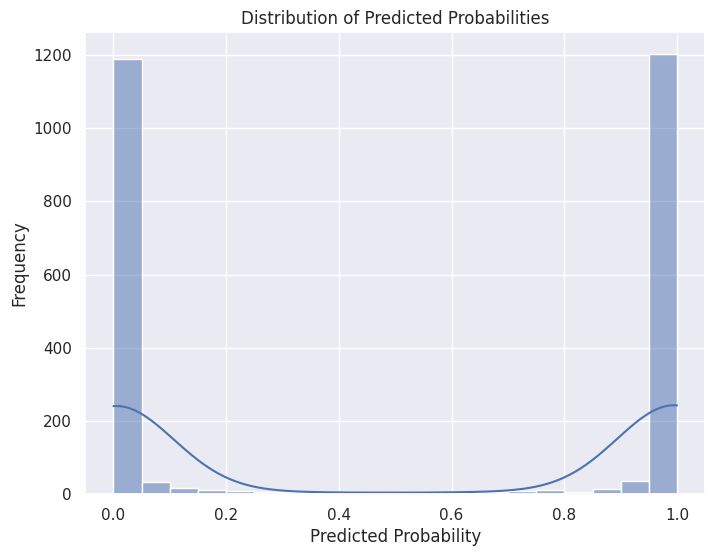

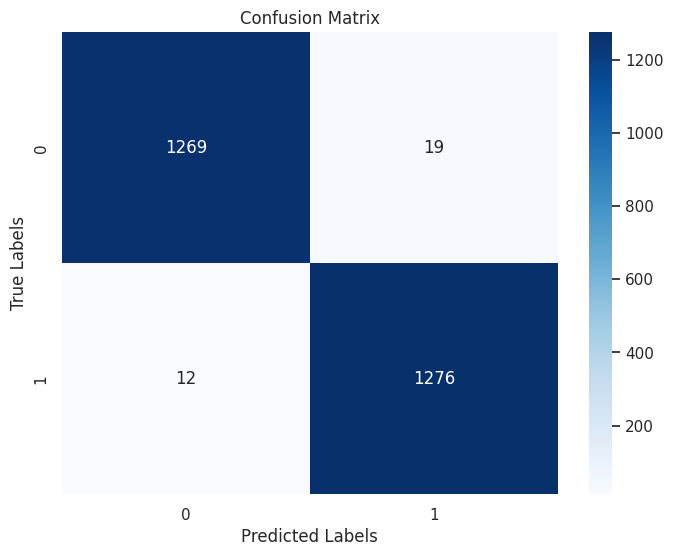

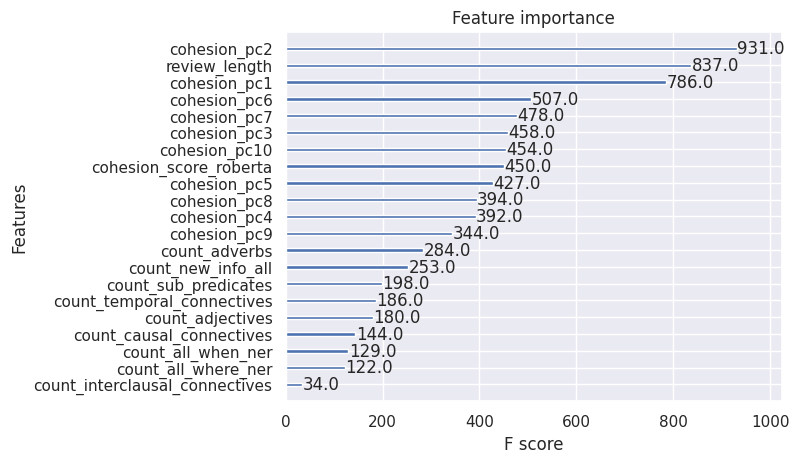

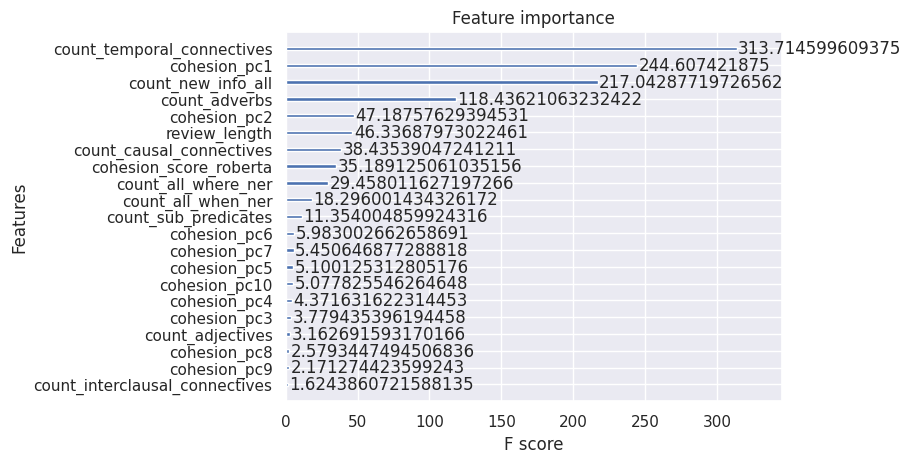

In [90]:
clf1.visualize_results()

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {'max_depth' : [2,3,4],
              'n_estimators' : [500,1000,2000],
              'learning_rate' : [1e-2, 3e-2, 1e-3],
              'tree_method' : ['exact', 'approx']
             }
clf1.fine_tune_hyperparameters(param_grid)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best hyperparameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 2000, 'tree_method': 'approx'}
Best ROC AUC score: 0.9987281142470149
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=1000, tree_method=exact;, score=0.998 total time=  29.8s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=2000, tree_method=approx;, score=0.998 total time=  43.4s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=2000, tree_method=exact;, score=0.999 total time= 1.6min
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=2000, tree_method=approx;, score=0.999 total time=  47.3s
[CV 2/5] END learning_rate=0.03, max_depth=2, n_estimators=1000, tree_method=approx;, score=0.999 total time=  21.7s
[CV 3/5] END learning_rate=0.03, max_depth=2, n_estimators=2000, tree_method=exact;, score=0.999 total time= 1.0min
[CV 2/5] END learning_rate=0.03, max_depth=3, n_estimators=2000, tree_method=exact;, score=

[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=500, tree_method=approx;, score=0.997 total time=   9.7s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=1000, tree_method=approx;, score=0.997 total time=  20.7s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, tree_method=exact;, score=0.998 total time=  24.5s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, tree_method=exact;, score=0.998 total time=  48.0s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=500, tree_method=exact;, score=0.998 total time=  32.1s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=1000, tree_method=exact;, score=0.999 total time= 1.0min
[CV 2/5] END learning_rate=0.03, max_depth=2, n_estimators=500, tree_method=approx;, score=0.998 total time=  10.8s
[CV 5/5] END learning_rate=0.03, max_depth=2, n_estimators=500, tree_method=approx;, score=0.998 total time=  10.9s
[CV 1/5] END learning_rate=0.03, max_depth=2, n_estimators=2000, tree_met

[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=1000, tree_method=exact;, score=0.998 total time=  30.0s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=2000, tree_method=approx;, score=0.998 total time=  43.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=2000, tree_method=exact;, score=0.999 total time= 1.6min
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=2000, tree_method=approx;, score=0.999 total time=  47.4s
[CV 1/5] END learning_rate=0.03, max_depth=2, n_estimators=1000, tree_method=approx;, score=0.999 total time=  21.7s
[CV 2/5] END learning_rate=0.03, max_depth=2, n_estimators=2000, tree_method=exact;, score=0.999 total time= 1.0min
[CV 1/5] END learning_rate=0.03, max_depth=3, n_estimators=2000, tree_method=exact;, score=0.999 total time= 1.5min
[CV 5/5] END learning_rate=0.03, max_depth=4, n_estimators=2000, tree_method=exact;, score=0.999 total time= 2.0min
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, tree

[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=500, tree_method=exact;, score=0.997 total time=  14.2s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=2000, tree_method=exact;, score=0.998 total time= 1.0min
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=2000, tree_method=exact;, score=0.998 total time= 1.5min
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=2000, tree_method=approx;, score=0.998 total time=  47.1s
[CV 3/5] END learning_rate=0.03, max_depth=2, n_estimators=1000, tree_method=approx;, score=0.999 total time=  21.6s
[CV 4/5] END learning_rate=0.03, max_depth=2, n_estimators=2000, tree_method=exact;, score=0.998 total time= 1.0min
[CV 3/5] END learning_rate=0.03, max_depth=3, n_estimators=2000, tree_method=exact;, score=0.999 total time= 1.5min
[CV 3/5] END learning_rate=0.03, max_depth=4, n_estimators=2000, tree_method=approx;, score=0.999 total time=  47.3s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=1000, tree

In [59]:
explainer, shap_values, X_display = clf1.build_shap_explainer()

In [65]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :]
)

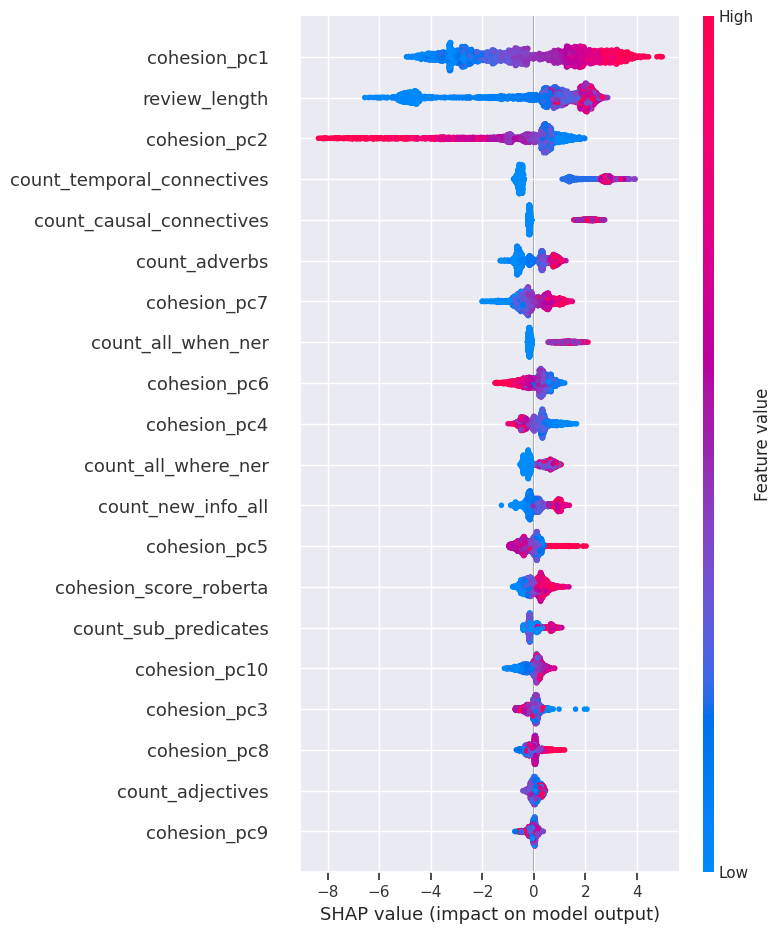

In [61]:
shap.summary_plot(shap_values, X_display)

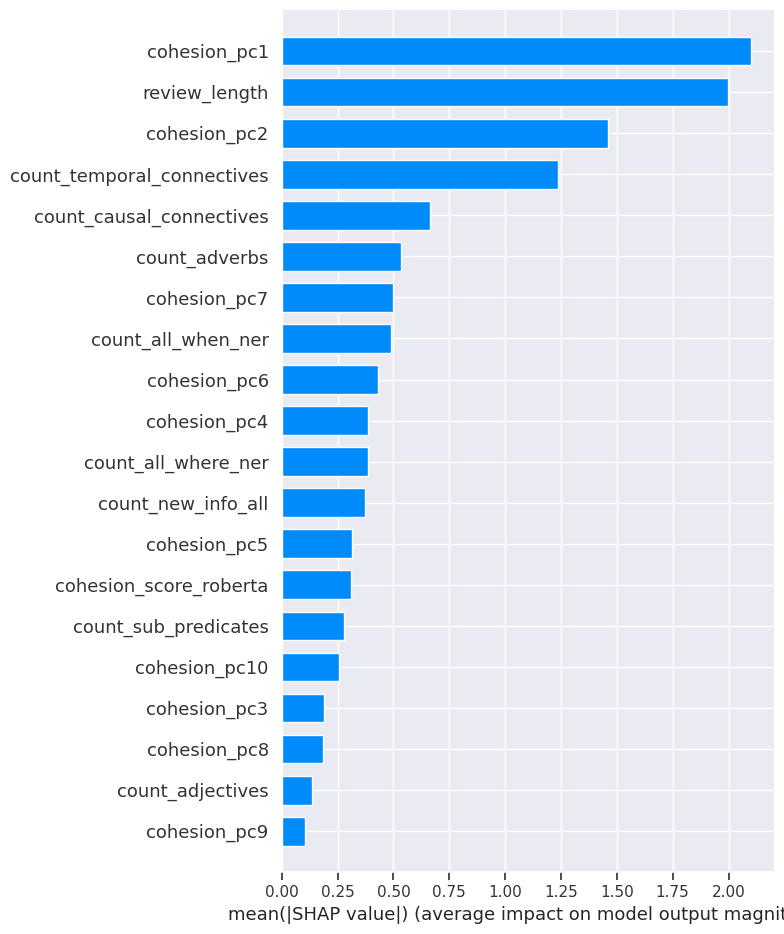

In [62]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

In [63]:
X_display.shape

(2575, 21)